# MovieLens Recommendation System

# 1. Business Understanding
## a. Introduction
The MovieLens dataset is a valuable resource for building and enhancing recommendation systems, and it can serve various business goals. The goal of a recommendation system is to expose people to items that they will like. It predicts the future preference of a set of items for a user, and recommends the top items from this set. In today's world, due to the internet and its global reach, people have more options to choose from than ever before.

Recommendation systems are a popular way for users to sort through millions of items to find the ones that are customized exactly for them. Recommendation systems cast a direct impact on profitability and customer satisfaction for most businesses today. With the nearly limitless options consumers have for products online, they need some guidance. Here, the MovieLens recommendation system helps in suggesting the movies which a customer might be interested in considering their past ratings history. 

The type of approach we will use for this recommendation system is the personalized recommendation system where we make use of different similarity metrics to determine how "similar" items are to one another. The most common similarity metric we will use for this project is the cosine similarity.
 
## b. Problem Statement
Develop an effective movie recommendation system that leverages collaborative filtering and content-based filtering techniques based on user ratings and movie attributes. The goal is to provide personalized movie recommendations to users, addressing the cold start problem for new users and enhancing the user experience by suggesting movies tailored to their preferences and viewing history.

## c. Main Objective
The main objective is to create a recommendation system that accurately suggests movies to users based on their historical ratings and preferences.

## d. Specific Objectives
- To increase user engagement and satisfaction by delivering movie suggestions that align with the users' interests and preferences.
- To implement thorough evaluation metrics to measure the performance of the recommendation system and optimize the algorithms for better accuracy and relevance of recommendations.
- To utilize movie attributes such as genre, director, and cast to enhance recommendations through content-based filtering, providing a broader range of suggestions.
- To utilize user ratings and interactions to identify patterns and preferences, allowing for improved recommendations that align with individual tastes.
- To develop strategies to mitigate the cold start problem by providing meaningful recommendations to new users who have not provided any ratings yet.

## e. Defining the metric for success

Our model will be a success if it is able to provide the top 5 movie recommendations to a user based on their ratings of other movies.

## f. Experimental Design
1. Introduction
2. Importing the necessary libraries
3. Reading the data
4. Checking the data
5. Tidying the Dataset
6. Exploratory Data Analysis
7. Conclusions
8. Recommendations

## g. Data Understanding
The data that was used in this project was colected from:
- https://grouplens.org/datasets/movielens/latest/

We used the small dataset containing 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users.

# 2. Importing Libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds
from surprise import Reader, Dataset, KNNBasic
from surprise.model_selection import train_test_split
from surprise import accuracy

# 3. Reading The Data

In [3]:
# Loading the links dataset
links_data = pd.read_csv("links.csv")
links_data.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
# Loading the movies dataset
movies_data = pd.read_csv("movies.csv")
movies_data.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
# Loading the ratings dataset
ratings_data = pd.read_csv("ratings.csv")
ratings_data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [8]:
ratings_data.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [9]:
# Loading the tags dataset
tags_data = pd.read_csv("tags.csv")
tags_data.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


# 4. Data Wrangling
1.) checking for missing values

In [52]:
movies_data.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [53]:
ratings_data.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [54]:
links_data.isnull().sum()

movieId    0
imdbId     0
tmdbId     8
dtype: int64

In [65]:
# Dropping missing values from the links dataframe
links_data.dropna(subset = ['tmdbId'])

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [55]:
tags_data.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

2.) previewing the data types in the datasets

In [66]:
movies_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [59]:
# Checking for duplicates in the movies dataset
movies_data.movieId.nunique()

9742

In [68]:
links_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


In [62]:
# Checking for duplicates in the links dataset
links_data.movieId.nunique()

9742

In [13]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [57]:
tags_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


# 5. Exploratory Data Analysis

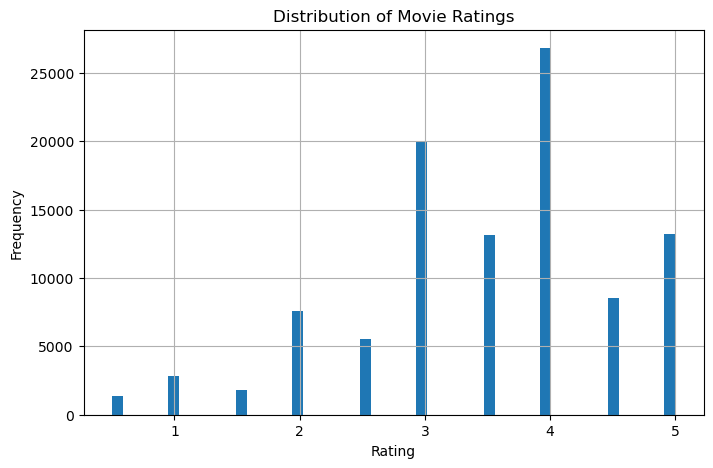

In [80]:
# showing the distribution of ratings via histogram
plt.figure(figsize=(8, 5))
plt.hist(ratings_data['rating'], bins=50)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 6. Tidying The Dataset

a. Item based filtering

In [81]:
item_data = ratings_data.pivot(index='movieId',columns='userId',values='rating')
item_data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
item_data.fillna(0,inplace=True)
item_data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


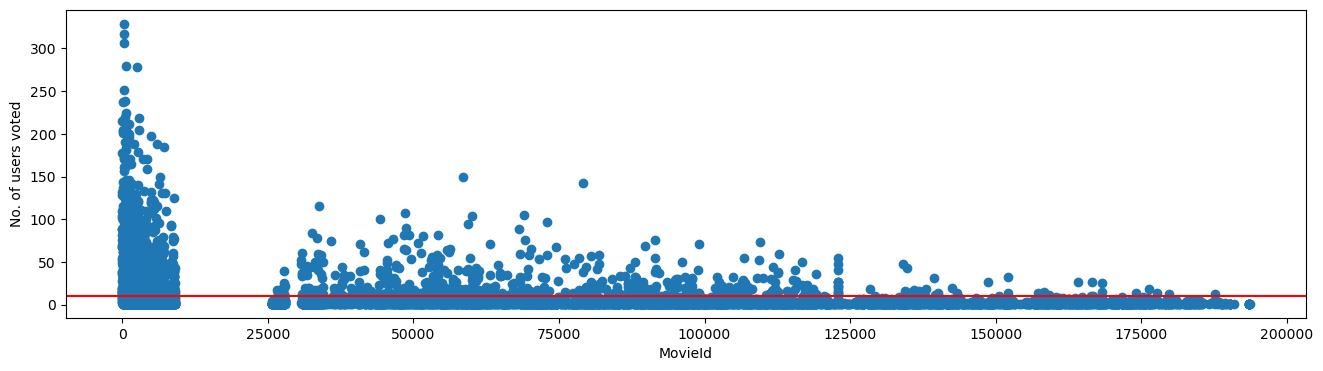

In [84]:
no_user_voted = ratings_data.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings_data.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted)
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [16]:
# Creating a reader object to specify the rating scale
reader = Reader(rating_scale=(0, 5))

In [18]:
# Loading the data into a Surprise Dataset
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

In [19]:
# Split the data into training set and testing set
trainset, testset = train_test_split(data, test_size=0.2)

In [20]:
# Creating an item-based collaborative filtering model
sim_options = {'name': 'cosine', 'user_based': False}
model = KNNBasic(sim_options=sim_options)

In [21]:
# Training the model on the training data
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [22]:
# Making predictions on the testing set
predictions = model.test(testset)

In [23]:
# Evaluating the model's performance using the Root Mean Squared Error
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse:.2f}')

RMSE: 0.9824
RMSE: 0.98


In [24]:
# Function to get a movie Recommendation for a specific user
def get_top_n_recommendations(predictions, n=10):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
    
    # Sort the predictions for each user and get the top n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [26]:
# Getting item-based movie recommendations for a specific user
user_id = 1  # Replace with the actual user ID
top_n_recommendations = get_top_n_recommendations(predictions, n=10)
user_recommendations = top_n_recommendations[user_id]

# Print the top recommendations for the user
print(f"Top {len(user_recommendations)} recommendations for User {user_id}:")
for movie_id, estimated_rating in user_recommendations:
    movie_title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
    print(f"{movie_title} (MovieId: {movie_id}, Estimated Rating: {estimated_rating:.2f})")


Top 10 recommendations for User 1:
Grumpier Old Men (1995) (MovieId: 3, Estimated Rating: 4.77)
L.A. Confidential (1997) (MovieId: 1617, Estimated Rating: 4.67)
South Park: Bigger, Longer and Uncut (1999) (MovieId: 2700, Estimated Rating: 4.63)
McHale's Navy (1997) (MovieId: 1445, Estimated Rating: 4.62)
Predator (1987) (MovieId: 3527, Estimated Rating: 4.62)
Spaceballs (1987) (MovieId: 3033, Estimated Rating: 4.60)
Big Trouble in Little China (1986) (MovieId: 3740, Estimated Rating: 4.60)
Indiana Jones and the Last Crusade (1989) (MovieId: 1291, Estimated Rating: 4.60)
Seven (a.k.a. Se7en) (1995) (MovieId: 47, Estimated Rating: 4.58)
So I Married an Axe Murderer (1993) (MovieId: 543, Estimated Rating: 4.57)


b. User-based filtering

In [27]:
# Creating a reader object to specify the rating scale
reader = Reader(rating_scale=(0, 5))

In [29]:
# Loading the data into a Surprise Dataset
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

In [30]:
# Splitting the data into a train set and a test set
trainset, testset = train_test_split(data, test_size=0.2)

In [31]:
# Creating a User-Based Collaborative Filtering method
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

In [32]:
# Training the model on the training set
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [33]:
# Making predictions on the test set
predictions = model.test(testset)

In [34]:
# Evaluating the model's performance using Root Mean Squared Error
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse:.2f}')

RMSE: 0.9673
RMSE: 0.97


In [35]:
# This function gets a movie recommendation for a specific user
def get_top_n_recommendations(predictions, n=10):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
    
    # Sort the predictions for each user and get the top n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

In [37]:
# Get user-based movie recommendations for a specific user
user_id = 1  # Replace with the actual user ID
top_n_recommendations = get_top_n_recommendations(predictions, n=10)
user_recommendations = top_n_recommendations[user_id]

# Print the top recommendations for the user
print(f"Top {len(user_recommendations)} recommendations for User {user_id}:")
for movie_id, estimated_rating in user_recommendations:
    movie_title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
    print(f"{movie_title} (MovieId: {movie_id}, Estimated Rating: {estimated_rating:.2f})")


Top 10 recommendations for User 1:
Forrest Gump (1994) (MovieId: 356, Estimated Rating: 4.38)
Star Wars: Episode IV - A New Hope (1977) (MovieId: 260, Estimated Rating: 4.35)
Back to the Future (1985) (MovieId: 1270, Estimated Rating: 4.29)
Saving Private Ryan (1998) (MovieId: 2028, Estimated Rating: 4.29)
Psycho (1960) (MovieId: 1219, Estimated Rating: 4.18)
Road Warrior, The (Mad Max 2) (1981) (MovieId: 3703, Estimated Rating: 4.12)
Run Lola Run (Lola rennt) (1998) (MovieId: 2692, Estimated Rating: 4.05)
Blues Brothers, The (1980) (MovieId: 1220, Estimated Rating: 3.98)
South Park: Bigger, Longer and Uncut (1999) (MovieId: 2700, Estimated Rating: 3.97)
Edward Scissorhands (1990) (MovieId: 2291, Estimated Rating: 3.78)


### c. Collaborative filtering
The key idea behind collaborative filtering is that similar users share similar interests and that users tend to like items that are similar to one another. The issue with collaborative filtering is that you have what is called the "cold start problem." The idea behind it is, how to recommend something based off of user activity if you do not have any user activity to begin with.

In [38]:
# Create a Reader object to specify the rating scale
reader = Reader(rating_scale=(1, 5))

# Load the data into a Surprise Dataset
data = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], reader)

# Split the data into a training set and a test set
trainset, testset = train_test_split(data, test_size=0.2)

# Create a User-Based Collaborative Filtering model
sim_options = {'name': 'cosine', 'user_based': True}
model = KNNBasic(sim_options=sim_options)

# Train the model on the training set
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

# Evaluate the model's performance using RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse:.2f}')

# Function to get movie recommendations for a specific user
def get_top_n_recommendations(predictions, n=10):
    top_n = {}
    for uid, iid, true_r, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = []
        top_n[uid].append((iid, est))
    
    # Sort the predictions for each user and get the top n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    return top_n

# Get movie recommendations for a specific user (replace 'user_id' with the actual user ID)
user_id = 1
top_n_recommendations = get_top_n_recommendations(predictions, n=10)
user_recommendations = top_n_recommendations[user_id]

# Print the top recommendations for the user
print(f"Top {len(user_recommendations)} recommendations for User {user_id}:")
for movie_id, estimated_rating in user_recommendations:
    movie_title = movies_data[movies_data['movieId'] == movie_id]['title'].values[0]
    print(f"{movie_title} (MovieId: {movie_id}, Estimated Rating: {estimated_rating:.2f})")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9770
RMSE: 0.98
Top 10 recommendations for User 1:
Matrix, The (1999) (MovieId: 2571, Estimated Rating: 4.53)
Star Wars: Episode IV - A New Hope (1977) (MovieId: 260, Estimated Rating: 4.28)
Star Wars: Episode V - The Empire Strikes Back (1980) (MovieId: 1196, Estimated Rating: 4.25)
American Beauty (1999) (MovieId: 2858, Estimated Rating: 4.24)
Back to the Future (1985) (MovieId: 1270, Estimated Rating: 4.16)
Indiana Jones and the Last Crusade (1989) (MovieId: 1291, Estimated Rating: 4.14)
Heat (1995) (MovieId: 6, Estimated Rating: 4.08)
Blazing Saddles (1974) (MovieId: 3671, Estimated Rating: 3.99)
Ghostbusters (a.k.a. Ghost Busters) (1984) (MovieId: 2716, Estimated Rating: 3.99)
Dirty Dozen, The (1967) (MovieId: 2944, Estimated Rating: 3.96)


### d. Content-based filtering to address the cold start problem
For Content-Based Recommenders, the main idea is if you like an item, you will also like "similar" items. These systems are based on the characteristics of the items themselves. The advantage of a content-based recommender system is that it is a recommender system that gives the user a bit more information as to why they are seeing these recommendations.

Content-based filtering uses the features or "content" of items, movies in this case, to make recommendations. This approach is effective for addressing the cold start problem because it doesn't rely on user interactions but instead leverages item attributes to make recommendations. 


In [78]:
# Merge the movies and ratings data
movie_ratings = pd.merge(ratings_data, movies_data, on='movieId')

# Preprocess movie genres (you may preprocess other features as needed)
movie_ratings['genres'] = movie_ratings['genres'].str.replace('|', ' ')

# Sample a smaller subset of the data to reduce memory usage
sample_size = 1000
random_sample = movie_ratings.sample(n=sample_size, random_state=42)

# TF-IDF Vectorization of movie genres
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(random_sample['genres'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get movie recommendations using content-based filtering
def get_content_based_recommendations(movie_id, num_recommendations=10):
    try:
        # Get the index of the movie
        movie_index = movie_ratings[movie_ratings['movieId'] == movie_id].index[0]

        # Get similarity scores for the movie
        similarity_scores = list(enumerate(cosine_sim[movie_index]))

        # Sort movies based on similarity scores
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

        # Get the movie IDs of recommended movies (excluding the input movie)
        recommended_movie_ids = [score[0] for score in similarity_scores[1:num_recommendations+1]]

        # Get the movie titles and genres of recommended movies
        recommended_movies = movie_ratings.iloc[recommended_movie_ids][['movieId', 'title', 'genres']]

        return recommended_movies
    except IndexError:
        print(f"Movie with ID {movie_id} was not found in the sampled data.")

# Example: Get content-based recommendations for a specific movie (replace 'movie_id' with the actual movie ID)
movie_id = 123  # Replace with the actual movie ID
recommendations = get_content_based_recommendations(movie_id)
print("Content-based Recommendations for Movie ID", movie_id)
print(recommendations)


Movie with ID 123 was not found in the sampled data.
Content-based Recommendations for Movie ID 123
None


In [ ]:
# Demographic Filtering
C = movies_df["vote_average"].mean()
m = movies_df["vote_count"].quantile(0.9)
print("C: ", C)
print("m: ", m)
new_movies_df = movies_df.copy().loc[movies_df["vote_count"] >= m]
print(new_movies_df.shape)
def weighted_rating(x, C=C, m=m):
v = x["vote_count"]
R = x["vote_average"]
return (v/(v + m) * R) + (m/(v + m) * C)
new_movies_df["score"] = new_movies_df.apply(weighted_rating, axis=1)
new_movies_df = new_movies_df.sort_values('score', ascending=False)
new_movies_df[["title", "vote_count", "vote_average", "score"]].head(10)

def plot():
    popularity = movies_df.sort_values("popularity", ascending=False)
    plt.figure(figsize=(12, 6))
    plt.barh(popularity["title"].head(10), popularity["popularity"].head(10), align="center", color="skyblue")
    plt.gca().invert_yaxis()
    plt.title("Top 10 movies")
    plt.xlabel("Popularity")
    plt.show()
plot()